In [1]:
!pip install wordcloud

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [5]:
fake=pd.read_csv(r'/content/drive/MyDrive/fake news detection using LSTM/fake-real-news-dataset/data/Fake.csv')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

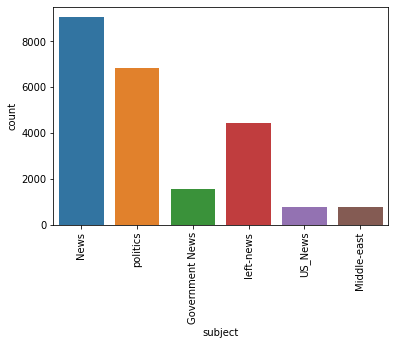

In [8]:
sns.countplot(x='subject',data=fake)
plt.xticks(rotation='90')

In [9]:
text = ' '.join(fake['text'].tolist()) #add text by space

(-0.5, 1919.5, 1079.5, -0.5)

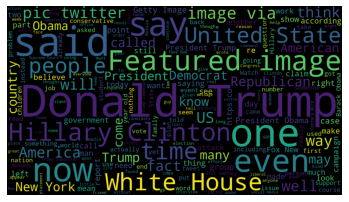

In [10]:
wordcloud=WordCloud(width=1920,height=1080).generate(text)
plt.imshow(wordcloud)
plt.axis('off')

In [11]:
real=pd.read_csv(r'/content/drive/MyDrive/fake news detection using LSTM/fake-real-news-dataset/data/True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
text = ' '.join(real['text'].tolist()) #add text by space

(-0.5, 1919.5, 1079.5, -0.5)

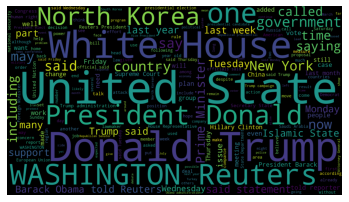

In [13]:
wordcloud=WordCloud(width=1920,height=1080).generate(text)
plt.imshow(wordcloud)
plt.axis('off')

In [14]:
#unknown publisher

unknown_publisher=[]
for index,row in enumerate(real.text.values):
    try:
        record= row.split(' - ',maxsplit=1)
        record[1]
        assert(len(record[0])<120)
    except:
        unknown_publisher.append(index)
    

In [15]:
len(unknown_publisher)

229

In [16]:
publisher=[]
tmp_text=[]

for index,row in enumerate(real.text.values):
    if index in unknown_publisher:
        tmp_text.append(row)
        publisher.append('Unknown')
    else:
        record=row.split(' - ',maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [17]:
real['publisher']=publisher
real['text']=tmp_text

In [18]:
real

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,worldnews,"August 22, 2017",BRUSSELS (Reuters)
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017",LONDON (Reuters)
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,worldnews,"August 22, 2017",MINSK (Reuters)
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017",MOSCOW (Reuters)


In [19]:
empty_fake_index=[index for index,row in enumerate(fake.text.tolist()) if str(row).strip()==""]

In [20]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [21]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['title']

In [22]:
real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

In [23]:
real['text']

0        as u.s. budget fight looms, republicans flip t...
1        u.s. military to accept transgender recruits o...
2        senior u.s. republican senator: 'let mr. muell...
3        fbi russia probe helped by australian diplomat...
4        trump wants postal service to charge 'much mor...
                               ...                        
21412    'fully committed' nato backs new u.s. approach...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy $1.14 billion worth of russia...
Name: text, Length: 21417, dtype: object

In [24]:
real['class']=1
fake['class']=0

In [25]:
real_data=pd.DataFrame({'text':real['text'].to_list(),'class':real['class']})

In [26]:
fake_data=pd.DataFrame({'text':fake['text'].to_list(),'class':fake['class']})

In [27]:
data=real_data.append(fake_data, ignore_index = True)

In [28]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 12.0 MB 69.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-flkhnmrw
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-flkhnmrw
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=3cb4f7e62c35a41c5ef0d904169bb51930f62a1a0a8cc9f0cd3ab17c40d7c24a
  Stored in directory: /tmp/pip-ephem-wheel-cache-l43wmoxt/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [29]:
import preprocess_kgptalkie as ps

In [30]:
data['text']= data['text'].apply(lambda x : ps.remove_special_chars(x))

In [31]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [32]:
import gensim

In [33]:
y= data['class'].values

In [34]:
x= [d.split() for d in data['text'].to_list()]

In [35]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences = x, min_count=1, window=10)

In [36]:
w2v_model.wv.most_similar('trump')

[('trumps', 0.7803092002868652),
 ('trumpcare', 0.5306798219680786),
 ('presidentelects', 0.5151201486587524),
 ('tweets', 0.4978092610836029),
 ('obama', 0.49680382013320923),
 ('rfk', 0.49391546845436096),
 ('faris', 0.4852331280708313),
 ('presidentelect', 0.47907209396362305),
 ('tapper', 0.4777081608772278),
 ('trumplike', 0.4685496389865875)]

In [37]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x)

In [38]:
X=tokenizer.texts_to_sequences(x)

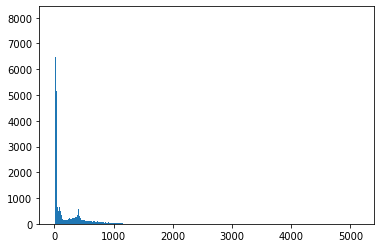

In [39]:
plt.hist([len(i) for i in X], bins=700)
plt.show()

In [40]:
nos= np.array([len(i) for i in X])
len(nos[nos>1000])

549

In [41]:
maxlen=1000
X = pad_sequences(X, maxlen=maxlen)

In [42]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [43]:
def get_weight_matrix(model):
    weight_matrix=np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        weight_matrix[i]=model.wv[word]
    return weight_matrix

In [44]:
embedding_vector = get_weight_matrix(w2v_model)

In [45]:
embedding_vector.shape

(90835, 100)

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights= [embedding_vector], input_length= maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         9083500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,200,877
Trainable params: 117,377
Non-trainable params: 9,083,500
_________________________________________________________________


In [47]:
X_train, X_test, y_train, y_test=train_test_split(X,y)

In [48]:
model.fit(X_train,y_train, epochs=6, validation_split=0.3)

Epoch 1/6
737/737 [==============================] - 40s 50ms/step - loss: 0.0503 - acc: 0.9856 - val_loss: 0.0044 - val_acc: 0.9993
Epoch 2/6
737/737 [==============================] - 35s 48ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0021 - val_acc: 0.9996
Epoch 3/6
737/737 [==============================] - 35s 48ms/step - loss: 0.0058 - acc: 0.9992 - val_loss: 0.0025 - val_acc: 0.9994
Epoch 4/6
737/737 [==============================] - 36s 49ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 5/6
737/737 [==============================] - 41s 55ms/step - loss: 0.0045 - acc: 0.9991 - val_loss: 0.0019 - val_acc: 0.9994
Epoch 6/6
737/737 [==============================] - 36s 49ms/step - loss: 6.0555e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9996


In [49]:
y_pred = (model.predict(X_test)>=0.5).astype(int)

In [50]:
accuracy_score(y_pred,y_test)

0.9999109131403118

In [51]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5802
           1       1.00      1.00      1.00      5423

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

